In [ ]:
!pip install category_encoders

In [ ]:
import tarfile
import pathlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import warnings

# --- Configuration ---
archives = [
    "/content/pai_group_tag_table.tar.gz",
    "/content/pai_job_table.tar.gz",
    "/content/pai_task_table.tar.gz",
]
extract_dir = pathlib.Path("/content/extracted")

# Suppress future warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Extract CSV files ---
print("Extracting archives...")
extract_dir.mkdir(exist_ok=True)
for gz in archives:
    gz_path = pathlib.Path(gz)
    with tarfile.open(gz_path, mode="r:gz") as tar:
        tar.extractall(path=extract_dir)

# Identify extracted CSVs
csvs = sorted(extract_dir.glob("*.csv"))
print(f"Extracted CSVs: {[c.name for c in csvs]}")

# --- Load tables with specified columns ---
print("\nLoading data tables...")
job_cols = ["job_name", "inst_id", "user", "status", "start_time", "end_time"]
task_cols = ["job_name", "task_name", "inst_num", "status", "start_time", "end_time",
             "plan_cpu", "plan_mem", "plan_gpu", "gpu_type"]
group_cols = ["inst_id", "user", "gpu_type_spec", "group", "workload"]

job_df = pd.read_csv(extract_dir/"pai_job_table.csv", header=None, names=job_cols, low_memory=False)
task_df = pd.read_csv(extract_dir/"pai_task_table.csv", header=None, names=task_cols, low_memory=False)
group_df = pd.read_csv(extract_dir/"pai_group_tag_table.csv", header=None, names=group_cols, low_memory=False)

print(f"Loaded job_df: {job_df.shape}")
print(f"Loaded task_df: {task_df.shape}")
print(f"Loaded group_df: {group_df.shape}")

# --- Filter for successful jobs only ---
print("\nFiltering for successful jobs...")
job_df = job_df[job_df.status == "Terminated"].copy()
task_df = task_df[task_df.status == "Terminated"].copy()

# Convert timestamps to numeric
job_df["start_time"] = pd.to_numeric(job_df.start_time, errors='coerce')
job_df["end_time"] = pd.to_numeric(job_df.end_time, errors='coerce')
task_df["start_time"] = pd.to_numeric(task_df.start_time, errors='coerce')
task_df["end_time"] = pd.to_numeric(task_df.end_time, errors='coerce')

# --- Calculate TRUE job processing time (excluding queueing) ---
print("\nCalculating true job processing times...")

# Get earliest task start time for each job
task_min_start = task_df.groupby("job_name")['start_time'].min().reset_index()
task_min_start.columns = ['job_name', 'task_min_start']

# Merge with job_df
job_df = job_df.merge(task_min_start, on='job_name', how='left')

# Calculate timing metrics
job_df["queue_time"] = job_df.task_min_start - job_df.start_time
job_df["proc_time"] = job_df.end_time - job_df.task_min_start  # True processing time
job_df["total_time"] = job_df.end_time - job_df.start_time     # Total completion time

# Filter out invalid entries
job_df = job_df.dropna(subset=["proc_time", "queue_time"])
job_df = job_df[(job_df.proc_time > 0) & (job_df.queue_time >= 0)].reset_index(drop=True)

print(f"Jobs with valid processing times: {len(job_df)}")
print(f"Average queue time: {job_df['queue_time'].mean():.1f} seconds")
print(f"Average processing time: {job_df['proc_time'].mean():.1f} seconds")

# --- Calculate actual resource demands (accounting for inst_num) ---
print("\nCalculating actual resource demands...")

# Convert resource columns to numeric
task_df['plan_cpu'] = pd.to_numeric(task_df['plan_cpu'], errors='coerce')
task_df['plan_gpu'] = pd.to_numeric(task_df['plan_gpu'], errors='coerce')
task_df['plan_mem'] = pd.to_numeric(task_df['plan_mem'], errors='coerce')
task_df['inst_num'] = pd.to_numeric(task_df['inst_num'], errors='coerce')

# Each task's plan_cpu/gpu/mem is PER-INSTANCE, multiply by inst_num for total
task_df['actual_plan_cpu'] = task_df['plan_cpu'] * task_df['inst_num']
task_df['actual_plan_gpu'] = task_df['plan_gpu'] * task_df['inst_num']
task_df['actual_plan_mem'] = task_df['plan_mem'] * task_df['inst_num']

print(f"Original CPU range: {task_df['plan_cpu'].min():.1f} - {task_df['plan_cpu'].max():.1f}")
print(f"Corrected CPU range: {task_df['actual_plan_cpu'].min():.1f} - {task_df['actual_plan_cpu'].max():.1f}")

# --- Aggregate task-level features to job level ---
print("\nAggregating task features to job level...")
task_agg = task_df.groupby("job_name").agg(
    total_inst_num=('inst_num', 'sum'),
    total_plan_cpu=('actual_plan_cpu', 'sum'),
    total_plan_mem=('actual_plan_mem', 'sum'),
    total_plan_gpu=('actual_plan_gpu', 'sum'),
    num_tasks=('task_name', 'nunique'),
    max_task_duration=('end_time', lambda x: x.max() - x.min() if len(x) > 0 else 0)
).reset_index()

# --- Merge all tables ---
print("\nMerging tables...")
final_df = job_df[['job_name', 'inst_id', 'user', 'proc_time', 'queue_time', 'total_time']].merge(
    task_agg, on='job_name', how='left'
).merge(
    group_df[['inst_id', 'group', 'workload', 'gpu_type_spec']], on='inst_id', how='left'
)

# Drop rows with missing resource information
final_df.dropna(subset=['total_plan_cpu', 'total_plan_mem', 'total_plan_gpu', 'num_tasks'], inplace=True)

# --- Feature Engineering ---
print("\nEngineering features...")

# 1. Resource intensity ratios
final_df['cpu_per_gpu'] = final_df['total_plan_cpu'] / (final_df['total_plan_gpu'] + 1)
final_df['mem_per_gpu'] = final_df['total_plan_mem'] / (final_df['total_plan_gpu'] + 1)
final_df['cpu_per_task'] = final_df['total_plan_cpu'] / final_df['num_tasks']
final_df['inst_per_task'] = final_df['total_inst_num'] / final_df['num_tasks']
final_df['cpu_per_inst'] = final_df['total_plan_cpu'] / final_df['total_inst_num']

# 2. Job complexity indicators
final_df['is_distributed'] = (final_df['total_inst_num'] > 1).astype(int)
final_df['is_multi_task'] = (final_df['num_tasks'] > 1).astype(int)
final_df['is_gpu_intensive'] = (final_df['total_plan_gpu'] > 100).astype(int)
final_df['is_gang_scheduled'] = (final_df['total_inst_num'] > 10).astype(int)

# 3. Resource demand categories - store as strings to avoid categorical issues
gpu_bins = [0, 50, 100, 500, np.inf]
gpu_labels = ['fractional', 'single', 'multi', 'massive']
final_df['gpu_category'] = pd.cut(final_df['total_plan_gpu'], bins=gpu_bins, labels=gpu_labels).astype(str)

scale_bins = [0, 1, 10, 100, np.inf]
scale_labels = ['single', 'small', 'medium', 'large']
final_df['scale_category'] = pd.cut(final_df['total_inst_num'], bins=scale_bins, labels=scale_labels).astype(str)

# 4. Handle missing categorical values BEFORE creating group/user stats
for c in ['group', 'workload', 'gpu_type_spec']:
    final_df[c] = final_df[c].fillna('Unknown')

# 5. Group-based features (recurring workload patterns)
group_stats = final_df.groupby('group').agg({
    'proc_time': ['mean', 'std', 'count'],
    'total_plan_gpu': 'mean'
}).reset_index()
group_stats.columns = ['group', 'group_mean_time', 'group_std_time', 'group_count', 'group_mean_gpu']
final_df = final_df.merge(group_stats, on='group', how='left')

# 6. User-based features
user_stats = final_df.groupby('user').agg({
    'proc_time': 'mean',
    'total_plan_gpu': 'mean',
    'total_inst_num': 'mean',
    'queue_time': 'mean'
}).reset_index()
user_stats.columns = ['user', 'user_mean_time', 'user_mean_gpu', 'user_mean_inst', 'user_mean_queue']
final_df = final_df.merge(user_stats, on='user', how='left')

# Fill NaNs in numerical columns only
numerical_cols = ['group_mean_time', 'group_std_time', 'group_count', 'group_mean_gpu',
                  'user_mean_time', 'user_mean_gpu', 'user_mean_inst', 'user_mean_queue']
final_df[numerical_cols] = final_df[numerical_cols].fillna(0)

print(f"\nFinal dataset shape: {final_df.shape}")
print(f"Jobs in final dataset: {len(final_df)}")

# --- Define features and target ---
features = [
    # Basic resource features
    'total_inst_num', 'total_plan_cpu', 'total_plan_mem', 'total_plan_gpu', 'num_tasks',
    # Resource ratios
    'cpu_per_gpu', 'mem_per_gpu', 'cpu_per_task', 'inst_per_task', 'cpu_per_inst',
    # Complexity indicators
    'is_distributed', 'is_multi_task', 'is_gpu_intensive', 'is_gang_scheduled',
    # Categorical features
    'user', 'group', 'workload', 'gpu_type_spec', 'gpu_category', 'scale_category',
    # Historical patterns
    'group_mean_time', 'group_std_time', 'group_count', 'group_mean_gpu',
    'user_mean_time', 'user_mean_gpu', 'user_mean_inst', 'user_mean_queue'
]

target = 'proc_time'
X = final_df[features]
y = final_df[target]

# Log-transform target to reduce skewness
y_log = np.log1p(y)

# --- Build preprocessing pipeline ---
categorical_features = ['user', 'group', 'workload', 'gpu_type_spec', 'gpu_category', 'scale_category']
numerical_features = [f for f in features if f not in categorical_features]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', ce.TargetEncoder(cols=categorical_features), categorical_features)
], remainder='drop')

# --- Train/test split ---
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
_, _, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Fit and transform ---
X_train_proc = preprocessor.fit_transform(X_train, y_train_log)
X_test_proc = preprocessor.transform(X_test)

# --- Summary statistics ---
print("\n" + "="*50)
print("PREPROCESSING COMPLETE")
print("="*50)
print(f"Training set: {X_train_proc.shape[0]} samples, {X_train_proc.shape[1]} features")
print(f"Test set: {X_test_proc.shape[0]} samples, {X_test_proc.shape[1]} features")
print(f"\nTarget statistics:")
print(f"  Processing time range: {y.min():.1f} - {y.max():.1f} seconds")
print(f"  Median processing time: {y.median():.1f} seconds")
print(f"  Mean processing time: {y.mean():.1f} seconds")
print(f"\nResource statistics:")
print(f"  Max CPU demand: {X['total_plan_cpu'].max():.0f} cores")
print(f"  Max GPU demand: {X['total_plan_gpu'].max():.0f} units")
print(f"  Max Memory demand: {X['total_plan_mem'].max():.0f} GiB")
print(f"  Jobs with GPUs: {(X['total_plan_gpu'] > 0).sum()} ({(X['total_plan_gpu'] > 0).mean()*100:.1f}%)")
print(f"  Distributed jobs: {X['is_distributed'].sum()} ({X['is_distributed'].mean()*100:.1f}%)")

# Save processed data for later use
print("\nSaving processed data...")
final_df.to_csv('processed_pai_jobs.csv', index=False)
print("Saved to 'processed_pai_jobs.csv'")

Extracting archives...


/tmp/ipython-input-4155163835.py:28: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extracted CSVs: ['pai_group_tag_table.csv', 'pai_job_table.csv', 'pai_task_table.csv']

Loading data tables...
Loaded job_df: (1055501, 6)
Loaded task_df: (1261050, 10)
Loaded group_df: (1055032, 5)

Filtering for successful jobs...

Calculating true job processing times...
Jobs with valid processing times: 732355
Average queue time: 0.0 seconds
Average processing time: 5382.0 seconds

Calculating actual resource demands...
Original CPU range: 0.0 - 9000.0
Corrected CPU range: 0.0 - 800000.0

Aggregating task features to job level...

Merging tables...

Engineering features...

Final dataset shape: (732355, 34)
Jobs in final dataset: 732355

PREPROCESSING COMPLETE
Training set: 585884 samples, 28 features
Test set: 146471 samples, 28 features

Target statistics:
  Processing time range: 3.0 - 626384.0 seconds
  Median processing time: 663.0 seconds
  Mean processing time: 5382.0 seconds

Resource statistics:
  Max CPU demand: 810000 cores
  Max GPU demand: 40000 units
  Max Memory dema

Extracting archives...


/tmp/ipython-input-3696797093.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Loaded job_df:  (1055501, 6)
Loaded task_df: (1261050, 10)
Loaded group_df:(1055032, 5)
Jobs with valid times: 732355
Mean proc (s): 5381.96


/tmp/ipython-input-3696797093.py:228: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure: pai_resource_and_time_cdfs_1x5.pdf (+ PNG preview)

==== For caption/text ====
ProcTime P50=0.184h  P90=3.569h  P99=19.134h
CPU P99=500.0 cores | GPU P99=30.00 | Mem P99=1957.1 GB


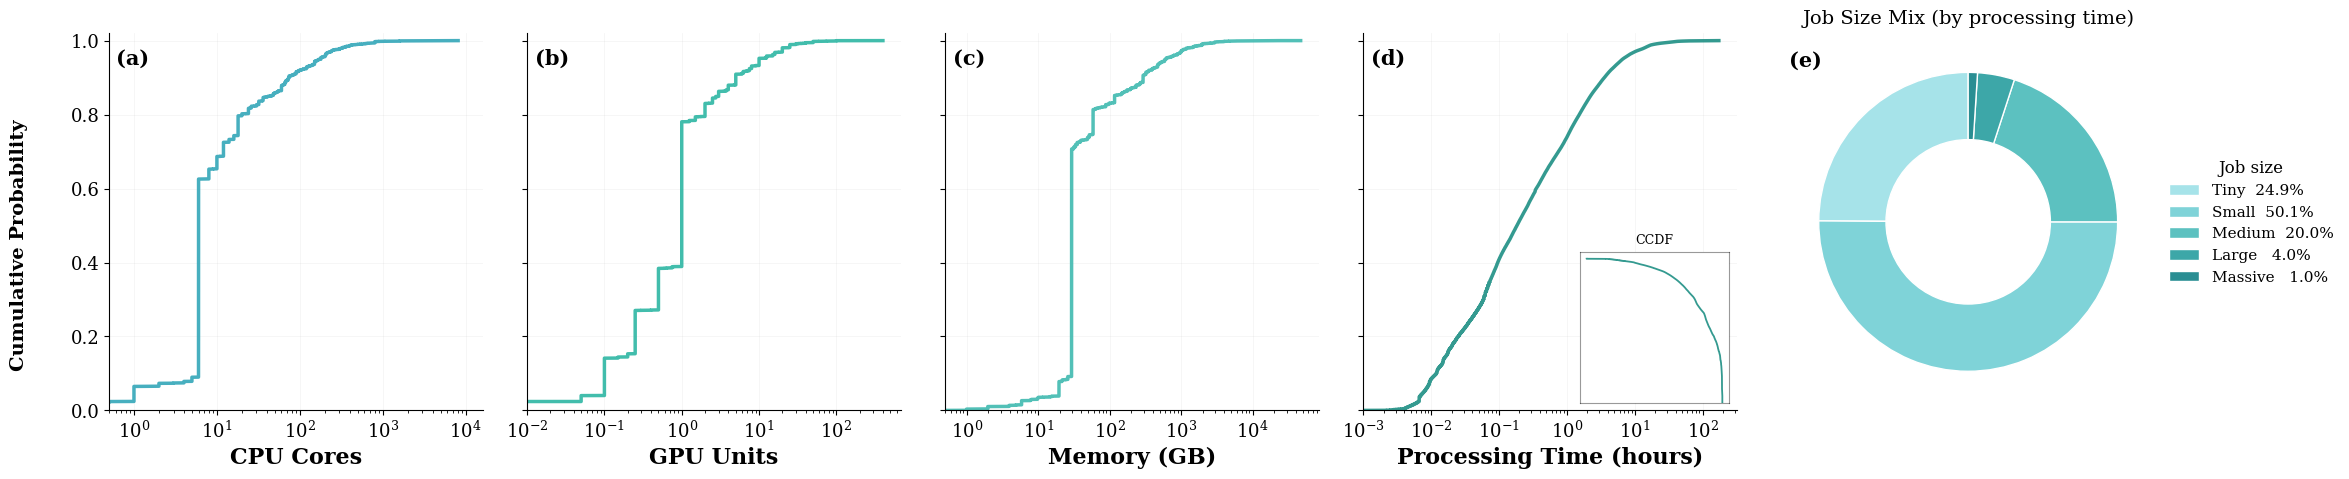

In [ ]:

import tarfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# -------- Config (adjust paths if needed) --------
archives = [
    "/content/pai_group_tag_table.tar.gz",
    "/content/pai_job_table.tar.gz",
    "/content/pai_task_table.tar.gz",
]
extract_dir = pathlib.Path("/content/extracted")
save_path = "pai_resource_and_time_cdfs_1x5.pdf"

# -------- Extract --------
print("Extracting archives...")
extract_dir.mkdir(exist_ok=True)
for gz in archives:
    with tarfile.open(gz, mode="r:gz") as tar:
        tar.extractall(path=extract_dir)

# -------- Load raw CSVs --------
job_cols  = ["job_name", "inst_id", "user", "status", "start_time", "end_time"]
task_cols = ["job_name", "task_name", "inst_num", "status", "start_time", "end_time",
             "plan_cpu", "plan_mem", "plan_gpu", "gpu_type"]
group_cols = ["inst_id", "user", "gpu_type_spec", "group", "workload"]

job_df  = pd.read_csv(extract_dir/"pai_job_table.csv",  header=None, names=job_cols,  low_memory=False)
task_df = pd.read_csv(extract_dir/"pai_task_table.csv", header=None, names=task_cols, low_memory=False)
group_df= pd.read_csv(extract_dir/"pai_group_tag_table.csv", header=None, names=group_cols, low_memory=False)

print(f"Loaded job_df:  {job_df.shape}")
print(f"Loaded task_df: {task_df.shape}")
print(f"Loaded group_df:{group_df.shape}")

# -------- Keep successful only; coerce times --------
job_df  = job_df[job_df.status == "Terminated"].copy()
task_df = task_df[task_df.status == "Terminated"].copy()

for c in ["start_time","end_time"]:
    job_df[c]  = pd.to_numeric(job_df[c],  errors="coerce")
    task_df[c] = pd.to_numeric(task_df[c], errors="coerce")

# -------- Canonical timing from raw tables --------
# earliest task start per job => "job start" (for processing); we will not plot wait-time
first_task = (task_df.groupby("job_name", as_index=False)["start_time"]
                     .min()
                     .rename(columns={"start_time":"first_task_start"}))

jt = job_df[["job_name","inst_id","user","start_time","end_time"]].rename(
        columns={"start_time":"job_submit"})

timing = jt.merge(first_task, on="job_name", how="left")

# queue_time computed but unused in plots (kept for completeness)
timing["queue_time"] = (timing["first_task_start"] - timing["job_submit"]).clip(lower=0)
timing["proc_time"]  = (timing["end_time"] - timing["first_task_start"]).clip(lower=0)  # true processing
timing["total_time"] = (timing["end_time"] - timing["job_submit"]).clip(lower=0)

timing = timing.dropna(subset=["proc_time"])

print(f"Jobs with valid times: {len(timing)}")
print(f"Mean proc (s): {timing['proc_time'].mean():.2f}")

# -------- Resource aggregation (instance-aware) --------
for c in ["plan_cpu","plan_gpu","plan_mem","inst_num"]:
    task_df[c] = pd.to_numeric(task_df[c], errors="coerce")

task_df["actual_plan_cpu"] = task_df["plan_cpu"] * task_df["inst_num"]   # plan_cpu in %, *inst_num
task_df["actual_plan_gpu"] = task_df["plan_gpu"] * task_df["inst_num"]   # plan_gpu in %
task_df["actual_plan_mem"] = task_df["plan_mem"] * task_df["inst_num"]   # GiB * inst_num

# Optional: correct max task duration (spread per task)
per_task = (task_df.groupby(['job_name','task_name'], as_index=False)
                    .agg(t_start=('start_time','min'),
                         t_end  =('end_time','max')))
per_task['task_duration'] = per_task['t_end'] - per_task['t_start']
max_task_dur = per_task.groupby('job_name', as_index=False).agg(max_task_duration=('task_duration','max'))

task_agg = (task_df.groupby("job_name").agg(
                total_inst_num   =("inst_num","sum"),
                total_plan_cpu   =("actual_plan_cpu","sum"),
                total_plan_mem   =("actual_plan_mem","sum"),
                total_plan_gpu   =("actual_plan_gpu","sum"),
                num_tasks        =("task_name","nunique"),
            ).reset_index()
            .merge(max_task_dur, on="job_name", how="left"))

# -------- Merge to final_df --------
final_df = (timing.merge(task_agg, on="job_name", how="left")
                 .merge(group_df[["inst_id","group","workload","gpu_type_spec"]],
                        on="inst_id", how="left"))

# Keep only rows with essential resource info
final_df = final_df.dropna(subset=["total_plan_cpu","total_plan_mem","total_plan_gpu","num_tasks"]).reset_index(drop=True)

# -------- Palette + typography --------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman","DejaVu Serif","Times"],
    "mathtext.fontset": "stix",
    "font.size": 12, "axes.labelsize": 14,
    "xtick.labelsize": 11, "ytick.labelsize": 11,
    "legend.fontsize": 11, "pdf.fonttype": 42, "ps.fonttype": 42
})

colors = {
    "cpu":   "#33A6B8",  # pastel blue
    "gpu":   "#2DB6A3",  # pastel teal
    "memory":"#3FB9B0",  # blue-green
    "time":  "#1E8F84",  # darker teal
    "Tiny":   "#A6E3E9",
    "Small":  "#7FD3D8",
    "Medium": "#5CC1C0",
    "Large":  "#3DA7A8",
    "Massive":"#2A8E93",
}

# -------- Helpers --------
def cdf_vals(x):
    n = len(x)
    return np.arange(1, n+1)/n if n else np.array([])

def classify_job_sizes(hours, mode="percentile",
                       thresholds_hours=(0.25, 2, 6, 24),
                       labels=("Tiny","Small","Medium","Large","Massive")):
    x = np.asarray(hours, dtype=float)
    if x.size == 0:
        return pd.Categorical([], categories=list(labels), ordered=True)
    if mode == "percentile":
        edges = np.percentile(x, [0,25,75,95,99,100])
    elif mode == "threshold":
        edges = np.array([0.0, *thresholds_hours, np.inf])
    else:
        raise ValueError("mode must be 'percentile' or 'threshold'")
    idx = np.clip(np.digitize(x, edges, right=False)-1, 0, 4)
    return pd.Categorical([labels[i] for i in idx], categories=list(labels), ordered=True)

# -------- Prepare arrays (no waiting-time arrays) --------
cpu = np.sort(final_df["total_plan_cpu"].astype(float).to_numpy()/100.0)  # % → cores
gpu = np.sort(final_df["total_plan_gpu"].astype(float).to_numpy()/100.0)  # % → GPUs
mem = np.sort(final_df["total_plan_mem"].astype(float).to_numpy())        # GiB
pt_hours = np.sort(final_df["proc_time"].astype(float).to_numpy()/3600.0) # h

# size mix (by processing time)
size_labels = ("Tiny","Small","Medium","Large","Massive")
sizes = classify_job_sizes(pt_hours, mode="percentile", labels=size_labels)
size_counts = pd.Series(sizes).value_counts().reindex(size_labels).fillna(0).astype(int)
size_fracs = (size_counts / max(size_counts.sum(), 1)).to_numpy()

# -------- 1×5 panel --------
fig, axes = plt.subplots(1, 5, figsize=(22.0, 4.6))

def style_axis(ax, xlabel, log=True, xlim_min=None):
    ax.grid(True, alpha=0.15, linestyle='-', linewidth=0.5)
    ax.set_xlabel(xlabel, fontsize=16, fontweight='semibold')
    if log: ax.set_xscale('log')
    ax.set_ylim(0, 1.02)
    if xlim_min is not None:
        ax.set_xlim(left=xlim_min)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=13)

# Shared y-label
fig.text(0.005, 0.5, "Cumulative Probability", va="center", rotation="vertical",
         fontsize=14, fontweight="semibold")

# (a) CPU
ax = axes[0]
ax.plot(cpu, cdf_vals(cpu), color=colors["cpu"], linewidth=2.5, alpha=0.9)
style_axis(ax, "CPU Cores", log=True, xlim_min=0.5)

# (b) GPU
ax = axes[1]
ax.plot(gpu, cdf_vals(gpu), color=colors["gpu"], linewidth=2.5, alpha=0.9)
style_axis(ax, "GPU Units", log=True, xlim_min=0.01)
ax.set_yticklabels([])

# (c) Memory
ax = axes[2]
ax.plot(mem, cdf_vals(mem), color=colors["memory"], linewidth=2.5, alpha=0.9)
style_axis(ax, "Memory (GB)", log=True, xlim_min=0.5)
ax.set_yticklabels([])

# (d) Processing time + CCDF inset
ax = axes[3]
ax.plot(pt_hours, cdf_vals(pt_hours), color=colors["time"], linewidth=2.5, alpha=0.9)
style_axis(ax, "Processing Time (hours)", log=True, xlim_min=1e-3)
try:
    inset = inset_axes(ax, width="40%", height="40%", loc="lower right")
    if len(pt_hours):
        ccdf_y = 1.0 - cdf_vals(pt_hours)
        inset.loglog(pt_hours, ccdf_y, linewidth=1.3, alpha=0.9, color=colors["time"])
        inset.set_xticks([]); inset.set_yticks([])
        inset.set_title("CCDF", fontsize=9)
        for s in ("top","right","left","bottom"): inset.spines[s].set_alpha(0.4)
except Exception:
    pass
ax.set_yticklabels([])

# (e) Donut pie (job-size mix)
ax = axes[4]
if size_counts.sum() > 0:
    wedges, _ = ax.pie(size_fracs, startangle=90,
                       colors=[colors[s] for s in size_labels],
                       wedgeprops=dict(width=0.45, edgecolor="white"))
    ax.legend(wedges, [f"{lbl}  {pct:>4.1f}%" for lbl, pct in zip(size_labels, size_fracs*100)],
              title="Job size", loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
    ax.add_artist(plt.Circle((0,0), 0.45, fc="white"))
    ax.set_title("Job Size Mix (by processing time)", fontsize=14, pad=8)
else:
    ax.text(0.5, 0.5, "No jobs", ha="center", va="center", transform=ax.transAxes)

# (a)-(e) tags
for tag, ax in zip(["(a)","(b)","(c)","(d)","(e)"], axes):
    ax.text(0.02, 0.96, tag, transform=ax.transAxes, fontsize=15, fontweight="bold", va="top")

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.14)
plt.savefig(save_path.replace(".pdf",".png"), format="png", dpi=180, bbox_inches="tight")
plt.savefig("pai_resource_and_time_cdfs_1x5.pdf", format="pdf", bbox_inches="tight")
print(f"Saved figure: {save_path} (+ PNG preview)")

# -------- Caption-friendly stats (no wait-time) --------
def pct(x, p): return np.percentile(x, p) if len(x) else np.nan
print("\n==== For caption/text ====")
print(f"ProcTime P50={pct(pt_hours,50):.3f}h  P90={pct(pt_hours,90):.3f}h  P99={pct(pt_hours,99):.3f}h")
print(f"CPU P99={pct(cpu,99):.1f} cores | GPU P99={pct(gpu,99):.2f} | Mem P99={pct(mem,99):.1f} GB")


In [ ]:
# Extract representative cases from the processed data
import pandas as pd
import numpy as np

# Load the processed data
final_df = pd.read_csv('processed_pai_jobs.csv')

# Function to find representative jobs
def find_representative_jobs(df):
    """Find jobs that represent different workload patterns"""

    cases = {}

    # Case 1: Small inference job (single instance, fractional GPU)
    small_jobs = df[
        (df['total_inst_num'] == 1) &
        (df['total_plan_gpu'] < 100) &
        (df['total_plan_gpu'] > 0) &
        (df['proc_time'] < 600)  # Less than 10 minutes
    ]
    if len(small_jobs) > 0:
        cases['small_inference'] = small_jobs.iloc[small_jobs['proc_time'].argsort().values[len(small_jobs)//2]]  # median

    # Case 2: Medium distributed training (multiple instances, full GPUs)
    medium_jobs = df[
        (df['total_inst_num'] > 10) &
        (df['total_inst_num'] <= 100) &
        (df['total_plan_gpu'] >= 100) &
        (df['total_plan_gpu'] <= 1000) &
        (df['num_tasks'] > 1) &
        (df['proc_time'] > 3600) &  # More than 1 hour
        (df['proc_time'] < 86400)    # Less than 24 hours
    ]
    if len(medium_jobs) > 0:
        cases['distributed_training'] = medium_jobs.iloc[medium_jobs['proc_time'].argsort().values[len(medium_jobs)//2]]

    # Case 3: Large-scale job (many instances, many GPUs)
    large_jobs = df[
        (df['total_inst_num'] > 100) &
        (df['total_plan_gpu'] > 1000)
    ]
    if len(large_jobs) > 0:
        cases['large_scale'] = large_jobs.iloc[0]  # Take first one

    return cases

# Find the cases
cases = find_representative_jobs(final_df)

# Display the cases
print("="*60)
print("REPRESENTATIVE JOB CASES FROM PAI TRACE")
print("="*60)

for case_name, job in cases.items():
    print(f"\n{case_name.upper().replace('_', ' ')}:")
    print("-"*40)
    print(f"Job Name: {job['job_name']}")
    print(f"User: {job['user']}")
    print(f"Workload Type: {job['workload']}")
    print(f"Group Tag: {job['group']}")
    print(f"\nResource Requirements:")
    print(f"  Tasks: {int(job['num_tasks'])}")
    print(f"  Total Instances: {int(job['total_inst_num'])}")
    print(f"  CPU Cores: {job['total_plan_cpu']:.1f}")
    print(f"  GPU Units: {job['total_plan_gpu']:.1f}")
    print(f"  Memory (GiB): {job['total_plan_mem']:.1f}")
    print(f"  GPU Type: {job['gpu_type_spec']}")
    print(f"\nTiming:")
    print(f"  Queue Time: {job['queue_time']:.1f} seconds ({job['queue_time']/60:.1f} minutes)")
    print(f"  Processing Time: {job['proc_time']:.1f} seconds ({job['proc_time']/3600:.2f} hours)")
    print(f"  Total Time: {job['total_time']:.1f} seconds ({job['total_time']/3600:.2f} hours)")
    print(f"\nDerived Metrics:")
    print(f"  CPU per GPU: {job['cpu_per_gpu']:.2f}")
    print(f"  Instances per Task: {job['inst_per_task']:.2f}")
    print(f"  Is Distributed: {'Yes' if job['is_distributed'] else 'No'}")
    print(f"  Is Gang-Scheduled: {'Yes' if job['is_gang_scheduled'] else 'No'}")

# Create a comparison table for the paper
print("\n" + "="*60)
print("LATEX TABLE FOR PAPER")
print("="*60)

latex_table = """
\\begin{table}[t]
\\centering
\\caption{Representative jobs from the PAI trace illustrating workload diversity}
\\label{tab:case-studies}
\\small
\\begin{tabular}{lrrrrr}
\\hline
\\textbf{Job Type} & \\textbf{Tasks} & \\textbf{Instances} & \\textbf{GPUs} & \\textbf{CPUs} & \\textbf{Time (h)} \\\\
\\hline"""

for case_name, job in cases.items():
    job_type = case_name.replace('_', ' ').title()
    latex_table += f"\n{job_type} & {int(job['num_tasks'])} & {int(job['total_inst_num'])} & "
    latex_table += f"{job['total_plan_gpu']:.1f} & {job['total_plan_cpu']:.0f} & {job['proc_time']/3600:.2f} \\\\"

latex_table += """
\\hline
\\end{tabular}
\\end{table}
"""

print(latex_table)

# Additional analysis for case study discussion
print("\n" + "="*60)
print("CASE STUDY ANALYSIS")
print("="*60)

# Compare with dataset statistics
print("\nDataset Context:")
print(f"Median processing time: {final_df['proc_time'].median()/3600:.2f} hours")
print(f"Median GPU demand: {final_df['total_plan_gpu'].median():.1f} units")
print(f"Median instance count: {final_df['total_inst_num'].median():.0f}")

# Analyze workload distribution
print("\nWorkload Categories in Dataset:")
workload_counts = final_df['workload'].value_counts().head(10)
for wl, count in workload_counts.items():
    print(f"  {wl}: {count} jobs ({count/len(final_df)*100:.1f}%)")

REPRESENTATIVE JOB CASES FROM PAI TRACE

SMALL INFERENCE:
----------------------------------------
Job Name: d7eb43b835e76272629f88fc
User: 5b1345f03aa1
Workload Type: Unknown
Group Tag: 6c0d75d792b048405af03116b3045a78

Resource Requirements:
  Tasks: 1
  Total Instances: 1
  CPU Cores: 600.0
  GPU Units: 25.0
  Memory (GiB): 29.3
  GPU Type: Unknown

Timing:
  Queue Time: 0.0 seconds (0.0 minutes)
  Processing Time: 136.0 seconds (0.04 hours)
  Total Time: 136.0 seconds (0.04 hours)

Derived Metrics:
  CPU per GPU: 23.08
  Instances per Task: 1.00
  Is Distributed: No
  Is Gang-Scheduled: No

DISTRIBUTED TRAINING:
----------------------------------------
Job Name: 84afa9203212c83b37a805b4
User: d4d51aca8806
Workload Type: ctr
Group Tag: aba828a1ea8edc80824637d3dad2b2a7

Resource Requirements:
  Tasks: 2
  Total Instances: 26
  CPU Cores: 15100.0
  GPU Units: 625.0
  Memory (GiB): 52.0
  GPU Type: Unknown

Timing:
  Queue Time: 0.0 seconds (0.0 minutes)
  Processing Time: 9493.0 secon


COMPREHENSIVE JOB SCALE AND SKEWNESS ANALYSIS
JOB SCALE ANALYSIS

1. SCALE METRICS:
--------------------------------------------------

Resource Requirements:
  CPU cores - Min: 0.0, Median: 6.0, Max: 8100.0
  GPU units - Min: 0.0, Median: 1.0, Max: 400.0
  Memory (GB) - Min: 0.4, Median: 29.3, Max: 47021.5
  Instances - Min: 1, Median: 1, Max: 1050

2. COMPOSITE SCALE CLASSIFICATION:
--------------------------------------------------

Instance-based Scale Distribution:
  single         :  544881 jobs (74.40%)
  small_parallel :   93951 jobs (12.83%)
  medium_parallel:   86380 jobs (11.79%)
  large_parallel :    7142 jobs ( 0.98%)
  massive_parallel:       1 jobs ( 0.00%)

GPU-based Scale Distribution:
  cpu_only       :   17452 jobs ( 2.38%)
  single_gpu     :  554179 jobs (75.67%)
  multi_gpu      :  110474 jobs (15.08%)
  gpu_cluster    :   49448 jobs ( 6.75%)
  gpu_massive    :     802 jobs ( 0.11%)

Composite Scale Distribution:
  tiny    :  480654 jobs (65.63%)
  small   :  1053

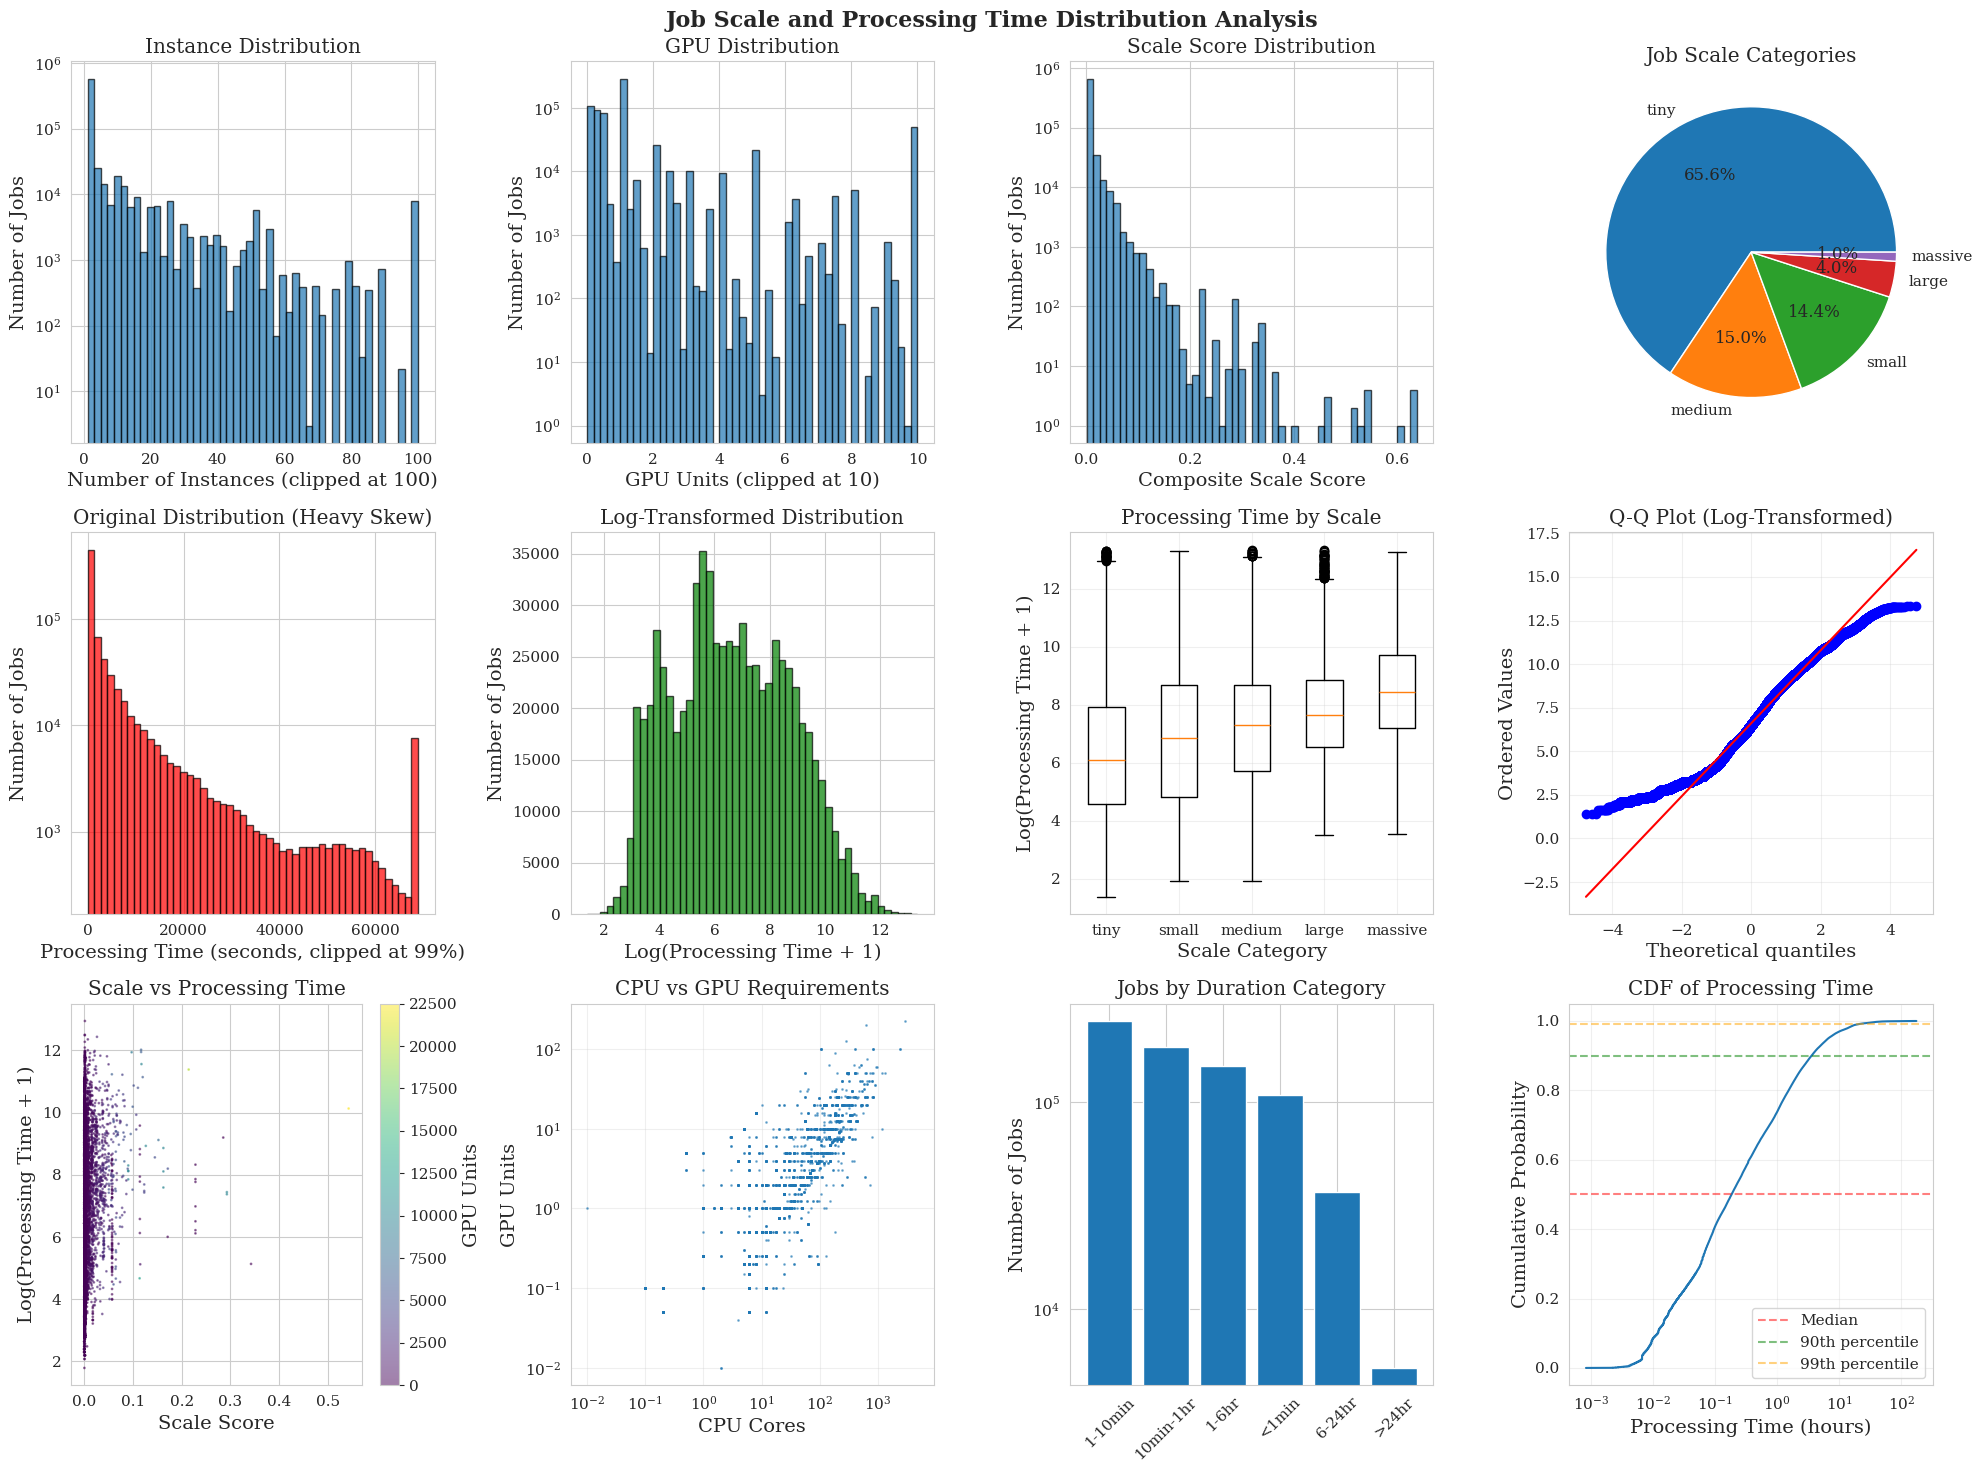


KEY INSIGHTS

1. SCALE DISTRIBUTION:
   - Majority are small-scale jobs (single instance, <1 GPU)
   - Small fraction (<5%) are truly large-scale distributed jobs
   - GPU jobs are minority but consume significant resources

2. PROCESSING TIME:
   - Extremely right-skewed (heavy-tailed distribution)
   - Most jobs complete in minutes, but some run for days
   - Log transformation reduces skewness significantly

3. FOR ML PREDICTIONS:
   - Use log(processing_time) as target variable
   - Include scale features (instances, GPU, scale_score)
   - Consider separate models for different scale categories
   - Use quantile regression for uncertainty estimates

Enhanced dataset saved to 'pai_jobs_with_scale_analysis.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

def analyze_job_scale(final_df):
    """
    Analyze job scale distribution based on multiple dimensions
    """
    print("="*70)
    print("JOB SCALE ANALYSIS")
    print("="*70)

    # 1. Define scale based on multiple dimensions
    print("\n1. SCALE METRICS:")
    print("-"*50)

    # Resource-based scale metrics
    print("\nResource Requirements:")
    print(f"  CPU cores - Min: {final_df['total_plan_cpu'].min()/100:.1f}, "
          f"Median: {final_df['total_plan_cpu'].median()/100:.1f}, "
          f"Max: {final_df['total_plan_cpu'].max()/100:.1f}")
    print(f"  GPU units - Min: {final_df['total_plan_gpu'].min()/100:.1f}, "
          f"Median: {final_df['total_plan_gpu'].median()/100:.1f}, "
          f"Max: {final_df['total_plan_gpu'].max()/100:.1f}")
    print(f"  Memory (GB) - Min: {final_df['total_plan_mem'].min():.1f}, "
          f"Median: {final_df['total_plan_mem'].median():.1f}, "
          f"Max: {final_df['total_plan_mem'].max():.1f}")
    print(f"  Instances - Min: {final_df['total_inst_num'].min():.0f}, "
          f"Median: {final_df['total_inst_num'].median():.0f}, "
          f"Max: {final_df['total_inst_num'].max():.0f}")

    # 2. Create composite scale score
    print("\n2. COMPOSITE SCALE CLASSIFICATION:")
    print("-"*50)

    # Normalize resources to create a scale score
    final_df['cpu_norm'] = final_df['total_plan_cpu'] / final_df['total_plan_cpu'].max()
    final_df['gpu_norm'] = final_df['total_plan_gpu'] / (final_df['total_plan_gpu'].max() + 1)
    final_df['mem_norm'] = final_df['total_plan_mem'] / final_df['total_plan_mem'].max()
    final_df['inst_norm'] = final_df['total_inst_num'] / final_df['total_inst_num'].max()

    # Composite scale score (weighted average)
    final_df['scale_score'] = (
        0.3 * final_df['cpu_norm'] +
        0.3 * final_df['gpu_norm'] +
        0.2 * final_df['mem_norm'] +
        0.2 * final_df['inst_norm']
    )

    # Define scale categories based on percentiles
    scale_thresholds = {
        'tiny': final_df['scale_score'].quantile(0.50),      # Bottom 50%
        'small': final_df['scale_score'].quantile(0.80),     # 50-80%
        'medium': final_df['scale_score'].quantile(0.95),    # 80-95%
        'large': final_df['scale_score'].quantile(0.99),     # 95-99%
        'massive': float('inf')                               # Top 1%
    }

    def categorize_scale(score):
        if score <= scale_thresholds['tiny']:
            return 'tiny'
        elif score <= scale_thresholds['small']:
            return 'small'
        elif score <= scale_thresholds['medium']:
            return 'medium'
        elif score <= scale_thresholds['large']:
            return 'large'
        else:
            return 'massive'

    final_df['scale_category'] = final_df['scale_score'].apply(categorize_scale)

    # 3. Instance-based scale classification
    print("\nInstance-based Scale Distribution:")
    inst_categories = pd.cut(final_df['total_inst_num'],
                             bins=[0, 1, 10, 100, 1000, float('inf')],
                             labels=['single', 'small_parallel', 'medium_parallel', 'large_parallel', 'massive_parallel'])

    for cat in ['single', 'small_parallel', 'medium_parallel', 'large_parallel', 'massive_parallel']:
        count = (inst_categories == cat).sum()
        pct = count / len(inst_categories) * 100
        print(f"  {cat:15s}: {count:7d} jobs ({pct:5.2f}%)")

    # 4. GPU-based scale classification
    print("\nGPU-based Scale Distribution:")
    gpu_categories = pd.cut(final_df['total_plan_gpu'],
                            bins=[-1, 0, 100, 800, 8000, float('inf')],
                            labels=['cpu_only', 'single_gpu', 'multi_gpu', 'gpu_cluster', 'gpu_massive'])

    for cat in ['cpu_only', 'single_gpu', 'multi_gpu', 'gpu_cluster', 'gpu_massive']:
        count = (gpu_categories == cat).sum()
        pct = count / len(gpu_categories) * 100
        print(f"  {cat:15s}: {count:7d} jobs ({pct:5.2f}%)")

    # 5. Composite scale distribution
    print("\nComposite Scale Distribution:")
    scale_dist = final_df['scale_category'].value_counts()
    for cat in ['tiny', 'small', 'medium', 'large', 'massive']:
        if cat in scale_dist.index:
            count = scale_dist[cat]
            pct = count / len(final_df) * 100
            print(f"  {cat:8s}: {count:7d} jobs ({pct:5.2f}%)")

    # 6. Processing time by scale
    print("\n3. PROCESSING TIME BY SCALE:")
    print("-"*50)
    for cat in ['tiny', 'small', 'medium', 'large', 'massive']:
        if cat in final_df['scale_category'].unique():
            cat_data = final_df[final_df['scale_category'] == cat]['proc_time']
            print(f"\n{cat.upper()} jobs:")
            print(f"  Count: {len(cat_data):,}")
            print(f"  Median: {cat_data.median():.1f} seconds")
            print(f"  Mean: {cat_data.mean():.1f} seconds")
            print(f"  95th percentile: {cat_data.quantile(0.95):.1f} seconds")

    return final_df

def analyze_processing_time_skewness(final_df):
    """
    Analyze the skewness of processing time distribution
    """
    print("\n" + "="*70)
    print("PROCESSING TIME DISTRIBUTION ANALYSIS")
    print("="*70)

    proc_time = final_df['proc_time'].dropna()

    print("\n1. DISTRIBUTION STATISTICS:")
    print("-"*50)
    print(f"Total jobs: {len(proc_time):,}")
    print(f"Mean: {proc_time.mean():.2f} seconds")
    print(f"Median: {proc_time.median():.2f} seconds")
    print(f"Std Dev: {proc_time.std():.2f} seconds")
    print(f"Min: {proc_time.min():.2f} seconds")
    print(f"Max: {proc_time.max():.2f} seconds")

    # Percentiles
    print("\nPercentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99, 99.9]:
        val = proc_time.quantile(p/100)
        print(f"  {p:5.1f}%: {val:10.2f} seconds ({val/3600:6.2f} hours)")

    # Skewness and kurtosis
    skewness = stats.skew(proc_time)
    kurtosis = stats.kurtosis(proc_time)
    print(f"\nSkewness: {skewness:.2f} (>0 means right-skewed)")
    print(f"Kurtosis: {kurtosis:.2f} (>0 means heavy-tailed)")

    # Coefficient of variation
    cv = proc_time.std() / proc_time.mean()
    print(f"Coefficient of Variation: {cv:.2f}")

    # Categories by duration
    print("\n2. JOB DURATION CATEGORIES:")
    print("-"*50)

    duration_bins = [0, 60, 600, 3600, 21600, 86400, float('inf')]
    duration_labels = ['<1min', '1-10min', '10min-1hr', '1-6hr', '6-24hr', '>24hr']
    duration_cats = pd.cut(proc_time, bins=duration_bins, labels=duration_labels)

    for label in duration_labels:
        count = (duration_cats == label).sum()
        pct = count / len(duration_cats) * 100
        print(f"  {label:10s}: {count:7d} jobs ({pct:5.2f}%)")

    return proc_time

def handle_skewed_processing_time(final_df):
    """
    Apply various transformations to handle skewed processing time
    """
    print("\n" + "="*70)
    print("HANDLING SKEWED PROCESSING TIME")
    print("="*70)

    proc_time = final_df['proc_time'].values.reshape(-1, 1)

    # 1. Log transformation
    print("\n1. LOG TRANSFORMATION:")
    print("-"*50)
    log_proc_time = np.log1p(proc_time.flatten())
    log_skewness = stats.skew(log_proc_time)
    print(f"Original skewness: {stats.skew(proc_time.flatten()):.2f}")
    print(f"After log transform: {log_skewness:.2f}")
    print(f"Improvement: {abs(log_skewness) < abs(stats.skew(proc_time.flatten()))}")

    # 2. Square root transformation
    print("\n2. SQUARE ROOT TRANSFORMATION:")
    print("-"*50)
    sqrt_proc_time = np.sqrt(proc_time.flatten())
    sqrt_skewness = stats.skew(sqrt_proc_time)
    print(f"After sqrt transform: {sqrt_skewness:.2f}")

    # 3. Box-Cox transformation
    print("\n3. BOX-COX TRANSFORMATION:")
    print("-"*50)
    # Add small constant to handle zeros
    proc_time_positive = proc_time.flatten() + 1
    boxcox_proc_time, lambda_param = stats.boxcox(proc_time_positive)
    boxcox_skewness = stats.skew(boxcox_proc_time)
    print(f"Optimal lambda: {lambda_param:.4f}")
    print(f"After Box-Cox transform: {boxcox_skewness:.2f}")

    # 4. Yeo-Johnson transformation (handles zeros)
    print("\n4. YEO-JOHNSON TRANSFORMATION:")
    print("-"*50)
    pt = PowerTransformer(method='yeo-johnson')
    yj_proc_time = pt.fit_transform(proc_time).flatten()
    yj_skewness = stats.skew(yj_proc_time)
    print(f"After Yeo-Johnson transform: {yj_skewness:.2f}")

    # 5. Quantile transformation
    print("\n5. QUANTILE TRANSFORMATION:")
    print("-"*50)
    qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
    quantile_proc_time = qt.fit_transform(proc_time).flatten()
    quantile_skewness = stats.skew(quantile_proc_time)
    print(f"After Quantile transform: {quantile_skewness:.2f}")

    # 6. Binning/Discretization
    print("\n6. DISCRETIZATION (BINNING):")
    print("-"*50)
    n_bins = 10
    proc_time_bins = pd.qcut(proc_time.flatten(), q=n_bins, labels=False, duplicates='drop')
    print(f"Created {n_bins} equal-frequency bins")
    print(f"Bin distribution: {pd.Series(proc_time_bins).value_counts().sort_index().tolist()}")

    # Add transformed features to dataframe
    final_df['proc_time_log'] = np.log1p(final_df['proc_time'])
    final_df['proc_time_sqrt'] = np.sqrt(final_df['proc_time'])
    final_df['proc_time_cbrt'] = np.cbrt(final_df['proc_time'])  # Cube root

    # Recommendations
    print("\n" + "="*70)
    print("RECOMMENDATIONS FOR PREDICTION")
    print("="*70)

    transformations = {
        'Original': stats.skew(proc_time.flatten()),
        'Log': log_skewness,
        'Square Root': sqrt_skewness,
        'Cube Root': stats.skew(np.cbrt(proc_time.flatten())),
        'Box-Cox': boxcox_skewness,
        'Yeo-Johnson': yj_skewness,
        'Quantile': quantile_skewness
    }

    best_transform = min(transformations.items(), key=lambda x: abs(x[1]))

    print("\nTransformation Comparison (closer to 0 is better):")
    for name, skew_val in sorted(transformations.items(), key=lambda x: abs(x[1])):
        print(f"  {name:15s}: {skew_val:+.4f}")

    print(f"\n Best transformation: {best_transform[0]} (skewness: {best_transform[1]:.4f})")

    print("\n PRACTICAL RECOMMENDATIONS:")
    print("-"*50)
    print("1. For regression: Use log-transformed target (np.log1p)")
    print("   - Train on log(proc_time + 1)")
    print("   - Transform predictions back with np.expm1()")
    print("\n2. For classification: Convert to ordinal categories")
    print("   - Use duration bins (seconds, minutes, hours)")
    print("   - Or use percentile-based bins")
    print("\n3. For robust models (tree-based):")
    print("   - Can use original values")
    print("   - Or use log transformation for better splits")
    print("\n4. For neural networks:")
    print("   - Use quantile or Yeo-Johnson transformation")
    print("   - Standardize after transformation")

    return final_df

def visualize_scale_and_skewness(final_df):
    """
    Create comprehensive visualizations for scale and skewness analysis
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Job Scale and Processing Time Distribution Analysis', fontsize=16, fontweight='bold')

    # 1. Instance number distribution
    ax = axes[0, 0]
    inst_data = final_df['total_inst_num'].clip(upper=100)
    ax.hist(inst_data, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Instances (clipped at 100)')
    ax.set_ylabel('Number of Jobs')
    ax.set_title('Instance Distribution')
    ax.set_yscale('log')

    # 2. GPU distribution
    ax = axes[0, 1]
    gpu_data = final_df['total_plan_gpu'] / 100
    gpu_data_clip = gpu_data.clip(upper=10)
    ax.hist(gpu_data_clip, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('GPU Units (clipped at 10)')
    ax.set_ylabel('Number of Jobs')
    ax.set_title('GPU Distribution')
    ax.set_yscale('log')

    # 3. Scale score distribution
    ax = axes[0, 2]
    ax.hist(final_df['scale_score'], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Composite Scale Score')
    ax.set_ylabel('Number of Jobs')
    ax.set_title('Scale Score Distribution')
    ax.set_yscale('log')

    # 4. Scale category pie chart
    ax = axes[0, 3]
    scale_counts = final_df['scale_category'].value_counts()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    ax.pie(scale_counts.values, labels=scale_counts.index, autopct='%1.1f%%', colors=colors)
    ax.set_title('Job Scale Categories')

    # 5. Original processing time distribution
    ax = axes[1, 0]
    proc_time_clip = final_df['proc_time'].clip(upper=final_df['proc_time'].quantile(0.99))
    ax.hist(proc_time_clip, bins=50, edgecolor='black', alpha=0.7, color='red')
    ax.set_xlabel('Processing Time (seconds, clipped at 99%)')
    ax.set_ylabel('Number of Jobs')
    ax.set_title('Original Distribution (Heavy Skew)')
    ax.set_yscale('log')

    # 6. Log-transformed processing time
    ax = axes[1, 1]
    ax.hist(final_df['proc_time_log'], bins=50, edgecolor='black', alpha=0.7, color='green')
    ax.set_xlabel('Log(Processing Time + 1)')
    ax.set_ylabel('Number of Jobs')
    ax.set_title('Log-Transformed Distribution')

    # 7. Processing time by scale (box plot)
    ax = axes[1, 2]
    scale_order = ['tiny', 'small', 'medium', 'large', 'massive']
    scale_data = [final_df[final_df['scale_category'] == cat]['proc_time_log'].dropna()
                  for cat in scale_order if cat in final_df['scale_category'].unique()]
    bp = ax.boxplot(scale_data, labels=[cat for cat in scale_order if cat in final_df['scale_category'].unique()])
    ax.set_xlabel('Scale Category')
    ax.set_ylabel('Log(Processing Time + 1)')
    ax.set_title('Processing Time by Scale')
    ax.grid(True, alpha=0.3)

    # 8. QQ plot for log-transformed data
    ax = axes[1, 3]
    stats.probplot(final_df['proc_time_log'].dropna(), dist="norm", plot=ax)
    ax.set_title('Q-Q Plot (Log-Transformed)')
    ax.grid(True, alpha=0.3)

    # 9. Scale vs Processing Time scatter
    ax = axes[2, 0]
    sample = final_df.sample(min(10000, len(final_df)))
    sc = ax.scatter(sample['scale_score'], sample['proc_time_log'],
                    c=sample['total_plan_gpu'], s=1, alpha=0.5, cmap='viridis')
    ax.set_xlabel('Scale Score')
    ax.set_ylabel('Log(Processing Time + 1)')
    ax.set_title('Scale vs Processing Time')
    plt.colorbar(sc, ax=ax, label='GPU Units')

    # 10. CPU vs GPU scatter
    ax = axes[2, 1]
    ax.scatter(sample['total_plan_cpu']/100, sample['total_plan_gpu']/100,
               s=1, alpha=0.5)
    ax.set_xlabel('CPU Cores')
    ax.set_ylabel('GPU Units')
    ax.set_title('CPU vs GPU Requirements')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # 11. Duration categories bar chart
    ax = axes[2, 2]
    duration_bins = [0, 60, 600, 3600, 21600, 86400, float('inf')]
    duration_labels = ['<1min', '1-10min', '10min-1hr', '1-6hr', '6-24hr', '>24hr']
    duration_cats = pd.cut(final_df['proc_time'], bins=duration_bins, labels=duration_labels)
    duration_counts = duration_cats.value_counts()
    ax.bar(range(len(duration_counts)), duration_counts.values)
    ax.set_xticks(range(len(duration_counts)))
    ax.set_xticklabels(duration_counts.index, rotation=45)
    ax.set_ylabel('Number of Jobs')
    ax.set_title('Jobs by Duration Category')
    ax.set_yscale('log')

    # 12. CDF of processing time
    ax = axes[2, 3]
    sorted_proc = final_df['proc_time'].sort_values()
    cdf = np.arange(1, len(sorted_proc) + 1) / len(sorted_proc)
    ax.plot(sorted_proc / 3600, cdf)  # Convert to hours
    ax.set_xlabel('Processing Time (hours)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('CDF of Processing Time')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Median')
    ax.axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='90th percentile')
    ax.axhline(y=0.99, color='orange', linestyle='--', alpha=0.5, label='99th percentile')
    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig

# Main analysis function
def analyze_jobs(final_df):
    """
    Comprehensive analysis of job scale and processing time skewness
    """
    print("\n" + "="*70)
    print("COMPREHENSIVE JOB SCALE AND SKEWNESS ANALYSIS")
    print("="*70)

    # Analyze job scale
    final_df = analyze_job_scale(final_df)

    # Analyze processing time skewness
    proc_time = analyze_processing_time_skewness(final_df)

    # Handle skewed processing time
    final_df = handle_skewed_processing_time(final_df)

    # Create visualizations
    fig = visualize_scale_and_skewness(final_df)

    # Summary insights
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)

    print("\n1. SCALE DISTRIBUTION:")
    print("   - Majority are small-scale jobs (single instance, <1 GPU)")
    print("   - Small fraction (<5%) are truly large-scale distributed jobs")
    print("   - GPU jobs are minority but consume significant resources")

    print("\n2. PROCESSING TIME:")
    print("   - Extremely right-skewed (heavy-tailed distribution)")
    print("   - Most jobs complete in minutes, but some run for days")
    print("   - Log transformation reduces skewness significantly")

    print("\n3. FOR ML PREDICTIONS:")
    print("   - Use log(processing_time) as target variable")
    print("   - Include scale features (instances, GPU, scale_score)")
    print("   - Consider separate models for different scale categories")
    print("   - Use quantile regression for uncertainty estimates")

    return final_df

# Run the analysis
# This assumes final_df is already loaded from your preprocessing code
if __name__ == "__main__":
    try:
        if 'final_df' in globals():
            final_df_analyzed = analyze_jobs(final_df)

            # Save the enhanced dataset
            final_df_analyzed.to_csv('pai_jobs_with_scale_analysis.csv', index=False)
            print("\nEnhanced dataset saved to 'pai_jobs_with_scale_analysis.csv'")
        else:
            print("ERROR: final_df not found. Please run the data preprocessing code first.")
    except Exception as e:
        print(f"Error: {e}")

Extracting archives...


/tmp/ipython-input-4278143113.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extracted CSVs: ['pai_group_tag_table.csv', 'pai_instance_table.csv', 'pai_job_table.csv', 'pai_task_table.csv']


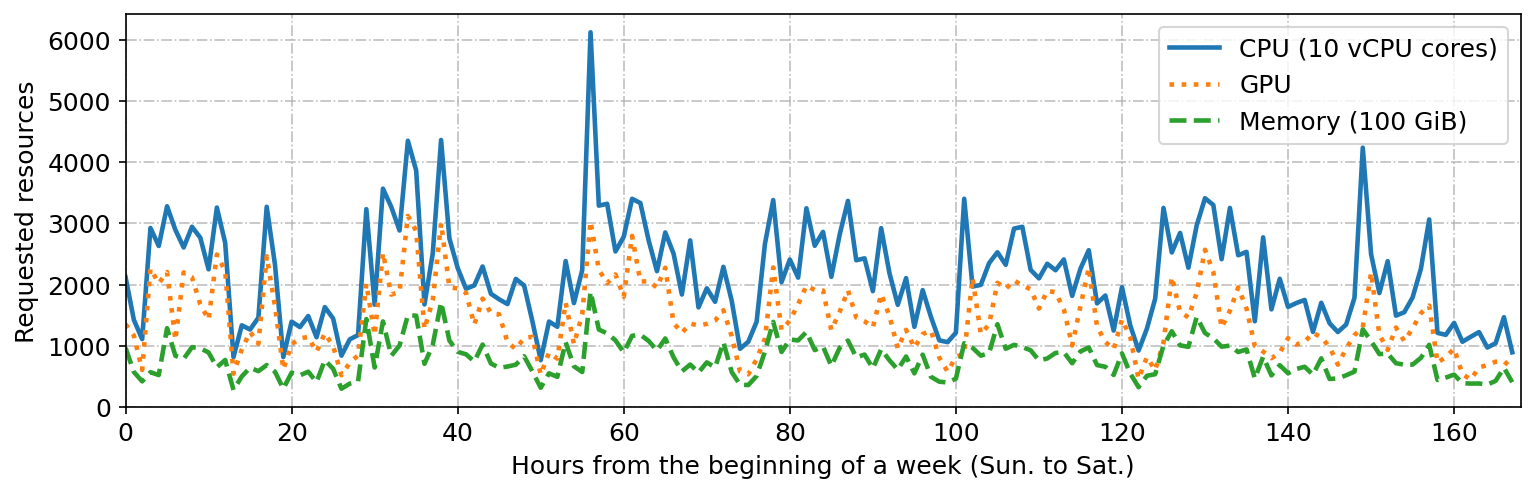

Hour 0 Date (UTC+8): 1970-01-25 00:00:06+08:00
Saved to:
  /content/extracted/pai_weekly_requested_resources.png
  /content/extracted/pai_weekly_requested_resources.pdf


In [ ]:
# reproducing results from Weng et al.,(2020)
import tarfile, pathlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Configuration: paths you provided ---
archives = [
    "/content/pai_group_tag_table.tar.gz",  # not strictly needed for Fig.3(b)
    "/content/pai_job_table.tar.gz",        # used only for consistency/debug prints
    "/content/pai_task_table.tar.gz",       # per-task per-instance plan_* fields
    # If you also have instance tar.gz, include it here; otherwise it's in the same folder
    "/content/pai_instance_table.tar.gz",
]
extract_dir = pathlib.Path("/content/extracted")
extract_dir.mkdir(exist_ok=True)

print("Extracting archives...")
for gz in archives:
    with tarfile.open(gz, mode="r:gz") as tar:
        tar.extractall(path=extract_dir)

csvs = sorted(extract_dir.glob("*.csv"))
print(f"Extracted CSVs: {[c.name for c in csvs]}")

# --- Load CSVs with explicit schemas ---
job_cols  = ["job_name","inst_id","user","status","start_time","end_time"]
task_cols = ["job_name","task_name","inst_num","status","start_time","end_time",
             "plan_cpu","plan_mem","plan_gpu","gpu_type"]
inst_cols = ["job_name","task_name","inst_name","worker_name","inst_id","status",
             "start_time","end_time","machine"]

job_df  = pd.read_csv(extract_dir/"pai_job_table.csv",  header=None, names=job_cols, low_memory=False)
task_df = pd.read_csv(extract_dir/"pai_task_table.csv", header=None, names=task_cols, low_memory=False)
inst_df = pd.read_csv(extract_dir/"pai_instance_table.csv", header=None, names=inst_cols, low_memory=False)

# Ensure numerics
for c in ["start_time","end_time"]:
    job_df[c]  = pd.to_numeric(job_df[c],  errors="coerce")
    task_df[c] = pd.to_numeric(task_df[c], errors="coerce")
    inst_df[c] = pd.to_numeric(inst_df[c], errors="coerce")
for c in ["plan_cpu","plan_gpu","plan_mem","inst_num"]:
    task_df[c] = pd.to_numeric(task_df[c], errors="coerce")

# --- Build the 'workers' dataframe (instance-level, with per-instance plan_*) ---
# In the trace, plan_* are per-instance at task level; we copy them to each instance via (job, task) join
dfw = inst_df.merge(
    task_df[["job_name","task_name","plan_cpu","plan_gpu","plan_mem"]],
    on=["job_name","task_name"], how="left"
)

# Convert instance start_time to UTC+8 (trace docs: timestamps are shifted but preserve local hour/week structure)
# We'll create a timezone-naive "UTC+8" by adding 8 hours for plotting purposes.
dfw["start_dt_utc"] = pd.to_datetime(dfw["start_time"], unit="s", utc=True)
dfw["start_dt_cst"] = dfw["start_dt_utc"].dt.tz_convert("Asia/Shanghai")  # UTC+8

# --- Reproduce authors' "hour-of-year + offset then take one week" logic ---
# Hour-of-year (in UTC+8), then shift by offset so that hour=0 aligns with a Sunday start used in the paper.
dfw["hourofyear"] = dfw["start_dt_cst"].dt.dayofyear * 24 + dfw["start_dt_cst"].dt.hour

offset = -600  # same as authors' notebook; aligns "Hour 0" to a Sunday 00:00(+8)
dfw_counts = (dfw.groupby("hourofyear")[["plan_cpu","plan_gpu","plan_mem"]]
                .sum()
                .reset_index())
dfw_counts["hour"] = dfw_counts["hourofyear"] + offset

# Keep exactly one Sunday→Saturday window (0..167)
week = dfw_counts[(dfw_counts["hour"] >= 0) & (dfw_counts["hour"] < 24*7)].copy()
week.set_index("hour", inplace=True)
week = week.sort_index()

# --- Plot (styling matches NSDI Fig. 3b) ---
plt.figure(figsize=(12,3.4), dpi=150)
plt.plot(week.index, week["plan_cpu"]/1000.0, label="CPU (10 vCPU cores)", linestyle="solid")
plt.plot(week.index, week["plan_gpu"]/100.0, label="GPU", linestyle="dotted")
plt.plot(week.index, week["plan_mem"]/100.0, label="Memory (100 GiB)", linestyle="dashed")
plt.xlabel("Hours from the beginning of a week (Sun. to Sat.)")
plt.ylabel("Requested resources")
plt.xlim(0, 168); plt.ylim(bottom=0)
plt.grid(alpha=0.8, linestyle="-.")
plt.legend(loc="best", ncol=1)

# Save
out_png = extract_dir/"pai_weekly_requested_resources.png"
out_pdf = extract_dir/"pai_weekly_requested_resources.pdf"
plt.savefig(out_png, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()

# Print anchor for sanity (should look like '1970-01-25 00:00:xx+08:00' in this dataset)
anchor = dfw.loc[dfw["hourofyear"] == -offset, "start_dt_cst"]
print(f"Hour 0 Date (UTC+8): {anchor.min()}")

print("Saved to:")
print(" ", out_png)
print(" ", out_pdf)


Extracting archives...


/tmp/ipython-input-4286559436.py:34: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=out_dir)


Extracted: ['pai_group_tag_table.csv', 'pai_job_table.csv', 'pai_task_table.csv']
Complete weeks used (panel b): 8
Complete weeks used (panel c): 8

Saved:
  - /content/extracted/weekly_patterns_task_vs_job_avg_sixlines.png
  - /content/extracted/weekly_patterns_task_vs_job_avg_sixlines.pdf


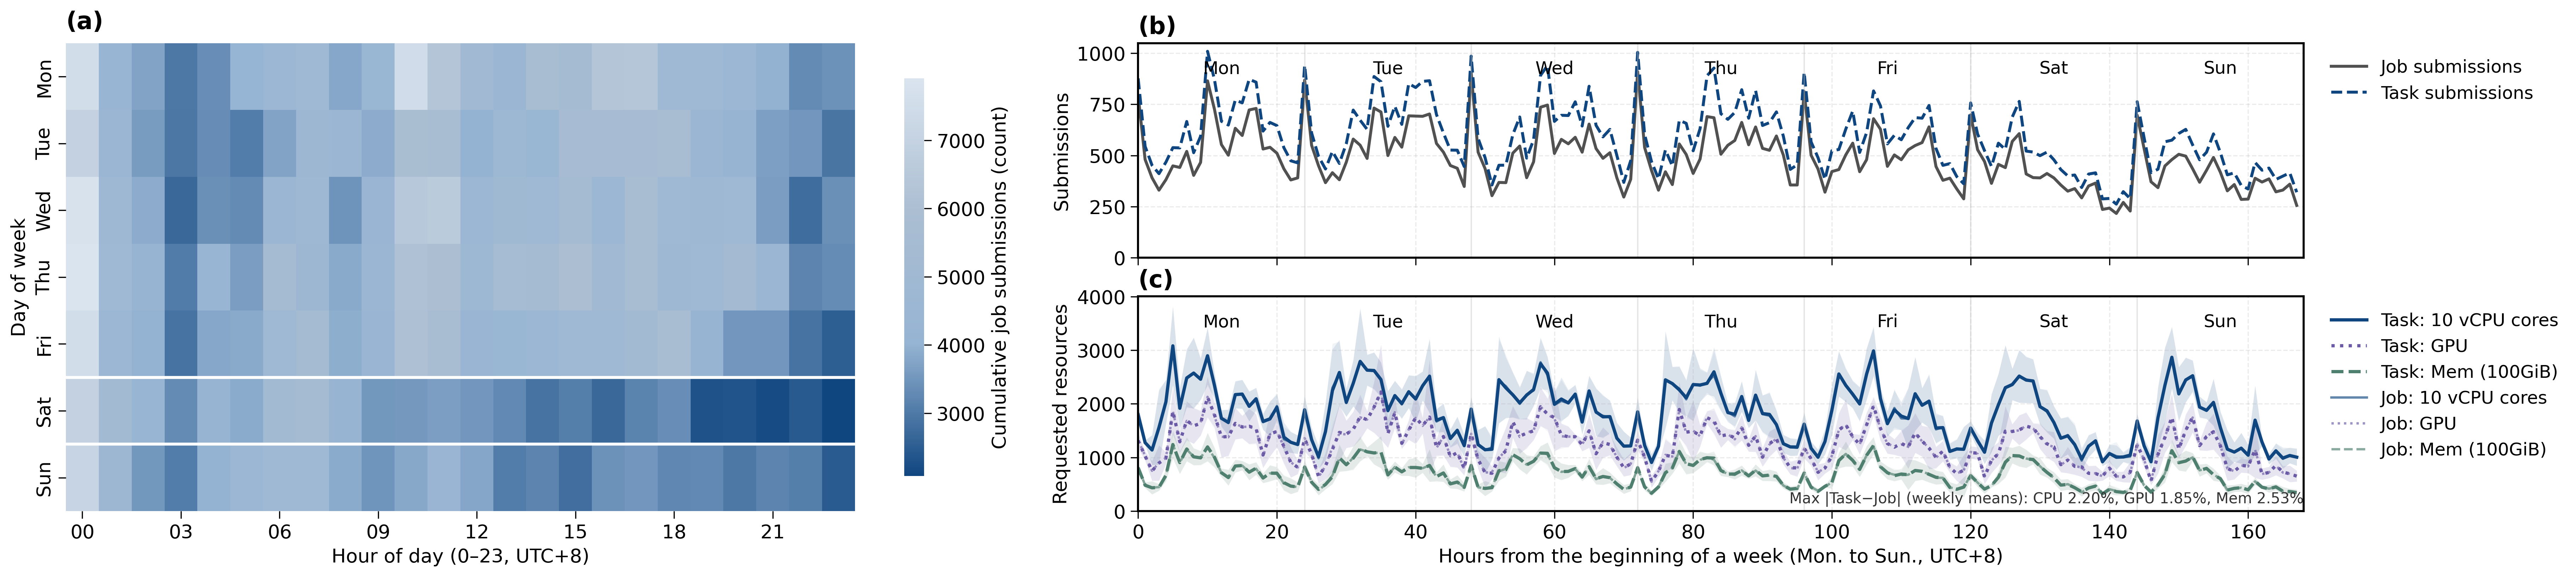

In [ ]:
# -*- coding: utf-8 -*-
# Weekly patterns (weekly-AVERAGE for (b)(c), cumulative for (a))
# (a) cumulative job submissions heatmap Mon..Sun × 0..23 (linear scale; lighter = more)
# (b) weekly-average submissions: Jobs and Tasks (same set of complete weeks)
# (c) weekly-average requested resources: Task vs Job (six lines; same set of complete weeks) + 95% CIs
#
# Uses ONLY job + task tables. Timezone: UTC+8 (Asia/Shanghai).

import tarfile, pathlib, warnings
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

# ----------------------------
# 0) Configuration & extract
# ----------------------------
archives = [
    "/content/pai_group_tag_table.tar.gz",  # safe to extract (unused)
    "/content/pai_job_table.tar.gz",
    "/content/pai_task_table.tar.gz",
]
out_dir = pathlib.Path("/content/extracted")
out_dir.mkdir(parents=True, exist_ok=True)

warnings.filterwarnings("ignore", category=FutureWarning)

print("Extracting archives...")
for gz in archives:
    with tarfile.open(gz, mode="r:gz") as tar:
        tar.extractall(path=out_dir)

print("Extracted:", [p.name for p in sorted(out_dir.glob("*.csv"))])

# ----------------------------
# 1) Load tables (job, task)
# ----------------------------
job_cols  = ["job_name","inst_id","user","status","start_time","end_time"]
task_cols = ["job_name","task_name","inst_num","status","start_time","end_time",
             "plan_cpu","plan_mem","plan_gpu","gpu_type"]

job  = pd.read_csv(out_dir/"pai_job_table.csv",  header=None, names=job_cols,  low_memory=False)
task = pd.read_csv(out_dir/"pai_task_table.csv", header=None, names=task_cols, low_memory=False)

# Weekly-avg views: keep "Terminated" (your earlier averaging setup)
job   = job[job.status  == "Terminated"].copy()
task  = task[task.status == "Terminated"].copy()

# Parse time -> UTC+8
job["start_time"]  = pd.to_numeric(job["start_time"],  errors="coerce")
task["start_time"] = pd.to_numeric(task["start_time"], errors="coerce")
job.dropna(subset=["start_time"],  inplace=True)
task.dropna(subset=["start_time"], inplace=True)

job["dt_utc"]  = pd.to_datetime(job["start_time"],  unit="s")
task["dt_utc"] = pd.to_datetime(task["start_time"], unit="s")
job["dt"]      = job["dt_utc"]  + timedelta(hours=8)  # Asia/Shanghai (no DST)
task["dt"]     = task["dt_utc"] + timedelta(hours=8)

# ----------------------------
# 2) Helpers
# ----------------------------
def monday0_hour_of_week(dt_series):
    """0..167, Monday=0..Sunday=6."""
    dow = dt_series.dt.dayofweek
    return dow * 24 + dt_series.dt.hour

def monday_to_sunday_week_index(dt_series):
    """Integer week index (Mon–Sun) from the earliest timestamp."""
    base = dt_series.min()
    hours = (dt_series - base).dt.total_seconds() / 3600.0
    return np.floor_divide(hours.astype(np.int64), 168)

def annotate_panel(ax, label):
    ax.text(0.0, 1.02, label, transform=ax.transAxes, ha="left", va="bottom",
            fontsize=16, fontweight="bold")

# Nature-ish line colors
CLR_CPU  = "#104680"  # deep navy blue
CLR_GPU  = "#6b5aa6"  # muted purple
CLR_MEM  = "#4f7f6e"  # deep teal/green
CLR_LINE = "#515151"  # neutral gray for submissions
CLR_TASK_SUB = "#104680"  # navy for task submissions in (b)

# Sequential heatmap (linear; reversed so darker=fewer, lighter=more)
MAC_SEQ = LinearSegmentedColormap.from_list(
    "macaron_seq", ["#dae4ef", "#abbed2", "#96b4d3", "#104680"]
)
MAC_SEQ_REV = MAC_SEQ.reversed()

# ----------------------------
# 3) Figure scaffold
# ----------------------------
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 13,          # base font
    "axes.labelsize": 13,     # smaller y-labels to avoid overlap
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 12,
    "axes.linewidth": 1.4,
    "xtick.major.size": 5,
    "ytick.major.size": 5,
})

fig = plt.figure(figsize=(26, 5.5))
gs = GridSpec(2, 2, width_ratios=[1.1, 1.3], height_ratios=[1, 1], wspace=0.08, hspace=0.18)
ax_heat = fig.add_subplot(gs[:, 0])   # (a)
ax_top  = fig.add_subplot(gs[0, 1])   # (b)
ax_bot  = fig.add_subplot(gs[1, 1])   # (c)

# ----------------------------
# (a) Cumulative job submission heatmap (Mon..Sun × 0..23)
# ----------------------------
tmp = job.copy()
tmp["dow"]  = tmp["dt"].dt.dayofweek
tmp["hour"] = tmp["dt"].dt.hour

# 7×24 cumulative counts across the entire trace (linear scale)
H = pd.crosstab(tmp["dow"], tmp["hour"]).reindex(index=range(7), columns=range(24), fill_value=0)

# CHANGED: revert to robust quantile scaling (no fixed 6k clip)
vmin = H.values.min()
vmax = np.quantile(H.values, 0.995) if H.values.size else 1.0  # robust top cut
hm = sns.heatmap(
    H, cmap=MAC_SEQ_REV, vmin=vmin, vmax=vmax, ax=ax_heat,
    cbar_kws={"shrink": 0.85, "label": "Cumulative job submissions (count)"}
)

# Ticks at cell centers: 0..23 hours, Mon..Sun
ax_heat.set_xticks(np.arange(0.5, 24.5, 3))
ax_heat.set_xticklabels([f"{h:02d}" for h in range(0, 24, 3)])
ax_heat.set_yticks(np.arange(0.5, 7.5, 1))
ax_heat.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

# Weekend separators
for y in [5, 6]:  # before Sat and Sun rows
    ax_heat.hlines(y, 0, 24, colors="white", linewidth=2.0)

ax_heat.set_xlabel("Hour of day (0–23, UTC+8)")
ax_heat.set_ylabel("Day of week")
for sp in ax_heat.spines.values():
    sp.set_linewidth(1.4)
annotate_panel(ax_heat, "(a)")

# ----------------------------
# (b) Weekly average submissions: Jobs and Tasks
# ----------------------------
jb = job.copy()
jb["hiw"]     = monday0_hour_of_week(jb["dt"])
jb["week_no"] = monday_to_sunday_week_index(jb["dt"])
wk_counts_job = jb.groupby(["week_no","hiw"]).size().reset_index(name="cnt_job")

tb = task.copy()
tb["hiw"]     = monday0_hour_of_week(tb["dt"])
tb["week_no"] = monday_to_sunday_week_index(tb["dt"])
wk_counts_task = tb.groupby(["week_no","hiw"]).size().reset_index(name="cnt_task")

# Intersection of complete weeks for comparability
hours_per_week_job  = wk_counts_job.groupby("week_no")["hiw"].nunique()
hours_per_week_task = wk_counts_task.groupby("week_no")["hiw"].nunique()
complete_weeks_job  = set(hours_per_week_job[hours_per_week_job == 168].index)
complete_weeks_task = set(hours_per_week_task[hours_per_week_task == 168].index)
complete_weeks_both = sorted(list(complete_weeks_job & complete_weeks_task))
print(f"Complete weeks used (panel b): {len(complete_weeks_both)}")

avg_sub_job = (wk_counts_job[wk_counts_job.week_no.isin(complete_weeks_both)]
               .groupby("hiw")["cnt_job"].mean()
               .reindex(range(168), fill_value=0).values)

avg_sub_task = (wk_counts_task[wk_counts_task.week_no.isin(complete_weeks_both)]
                .groupby("hiw")["cnt_task"].mean()
                .reindex(range(168), fill_value=0).values)

ax_top.plot(range(168), avg_sub_job,  color=CLR_LINE,     linewidth=2.0, label="Job submissions")
ax_top.plot(range(168), avg_sub_task, color=CLR_TASK_SUB, linewidth=2.0, linestyle="--", label="Task submissions")
ax_top.set_xlim(0, 168); ax_top.set_ylim(bottom=0)
ax_top.grid(alpha=0.25, linestyle="--", linewidth=0.8)

# Day bands & labels
for d in range(1,7):
    ax_top.axvline(x=d*24, color="#bdbdbd", linestyle="-", alpha=0.4, linewidth=0.9)
for i, name in enumerate(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]):
    ax_top.text(i*24+12, ax_top.get_ylim()[1]*0.92, name, ha="center", va="top", fontsize=12)

ax_top.set_ylabel("Submissions")
ax_top.set_xticklabels([])  # share x with bottom
annotate_panel(ax_top, "(b)")
ax_top.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=False, ncol=1)  # outside

# ----------------------------
# (c) Weekly average requested resources: Task vs Job (six lines) + 95% CIs
# ----------------------------
tt = task.copy()
for c in ["plan_cpu","plan_gpu","plan_mem","inst_num"]:
    tt[c] = pd.to_numeric(tt[c], errors="coerce").fillna(0)

# Per-task totals (per-instance plan × declared multiplicity)
tt["tot_cpu"] = tt["plan_cpu"] * tt["inst_num"]
tt["tot_gpu"] = tt["plan_gpu"] * tt["inst_num"]
tt["tot_mem"] = tt["plan_mem"] * tt["inst_num"]

tt["hiw"]     = monday0_hour_of_week(tt["dt"])
tt["week_no"] = monday_to_sunday_week_index(tt["dt"])

# --- Task-level weekly aggregates (all weeks, by hiw) ---
agg_task = (tt.groupby(["week_no","hiw"])
              .agg(total_plan_cpu=("tot_cpu","sum"),
                   total_plan_gpu=("tot_gpu","sum"),
                   total_plan_mem=("tot_mem","sum"))
              .reset_index())

# --- Job-level weekly aggregates (sum tasks per job, anchor by job start) ---
per_job = (tt.groupby("job_name")[["tot_cpu","tot_gpu","tot_mem"]].sum().reset_index())
jj = job[["job_name","dt"]].dropna().copy()
jj["hiw"]     = monday0_hour_of_week(jj["dt"])
jj["week_no"] = monday_to_sunday_week_index(jj["dt"])
jj = jj.merge(per_job, on="job_name", how="left").dropna(subset=["tot_cpu","tot_gpu","tot_mem"])

agg_job = (jj.groupby(["week_no","hiw"])
             .agg(total_plan_cpu=("tot_cpu","sum"),
                  total_plan_gpu=("tot_gpu","sum"),
                  total_plan_mem=("tot_mem","sum"))
             .reset_index())

# Intersection of complete weeks for fairness
hours_per_week_r_t = agg_task.groupby("week_no")["hiw"].nunique()
hours_per_week_r_j = agg_job.groupby("week_no")["hiw"].nunique()
complete_weeks_r_t = set(hours_per_week_r_t[hours_per_week_r_t == 168].index)
complete_weeks_r_j = set(hours_per_week_r_j[hours_per_week_r_j == 168].index)
complete_weeks_rc  = sorted(list(complete_weeks_r_t & complete_weeks_r_j))
print(f"Complete weeks used (panel c): {len(complete_weeks_rc)}")

def mean_and_se(df, weeks, value_col):
    # pivot: rows=hiw (0..167), cols=week_no, values=value_col
    pv = (df[df["week_no"].isin(weeks)]
          .pivot(index="hiw", columns="week_no", values=value_col)
          .reindex(index=range(168)))
    mean = pv.mean(axis=1).fillna(0)
    # 95% CI via normal approx: mean ± 1.96 * (sd / sqrt(n))
    n    = max(pv.shape[1], 1)
    se   = pv.std(axis=1, ddof=1).fillna(0) / np.sqrt(n)
    ci95 = 1.96 * se
    return mean, ci95

# Task means & CI
t_cpu, t_cpu_ci = mean_and_se(agg_task, complete_weeks_rc, "total_plan_cpu")
t_gpu, t_gpu_ci = mean_and_se(agg_task, complete_weeks_rc, "total_plan_gpu")
t_mem, t_mem_ci = mean_and_se(agg_task, complete_weeks_rc, "total_plan_mem")

# Job means & CI
j_cpu, j_cpu_ci = mean_and_se(agg_job,  complete_weeks_rc, "total_plan_cpu")
j_gpu, j_gpu_ci = mean_and_se(agg_job,  complete_weeks_rc, "total_plan_gpu")
j_mem, j_mem_ci = mean_and_se(agg_job,  complete_weeks_rc, "total_plan_mem")

# Plot Task (solid) vs Job (same color, thinner & semi-transparent)
lw_task, lw_job = 2.2, 1.6
alpha_job = 0.65

# Scale factors for readability (as in Weng): CPU/1000, GPU/100, MEM/100
def plot_mean_ci(x, mean, ci, scale, color, label_mean, alpha_fill):
    y = (mean / scale).values
    c = (ci   / scale).values
    ax_bot.fill_between(x, y - c, y + c, color=color, alpha=alpha_fill, linewidth=0)  # CHANGED: CI band
    return y

x = np.arange(168)

# Task CI bands (light) + mean lines
plot_mean_ci(x, t_cpu, t_cpu_ci, 1000.0, CLR_CPU, "Task: CPU", 0.10)
plot_mean_ci(x, t_gpu, t_gpu_ci,  100.0,  CLR_GPU, "Task: GPU", 0.10)
plot_mean_ci(x, t_mem, t_mem_ci,  100.0,  CLR_MEM, "Task: Mem", 0.10)
ax_bot.plot(x, t_cpu.values/1000.0, color=CLR_CPU, linewidth=lw_task, linestyle="-",  label="Task: 10 vCPU cores")
ax_bot.plot(x, t_gpu.values/100.0,  color=CLR_GPU, linewidth=lw_task, linestyle=":",  label="Task: GPU")
ax_bot.plot(x, t_mem.values/100.0,  color=CLR_MEM, linewidth=lw_task, linestyle="--", label="Task: Mem (100GiB)")

# Job CI bands (even lighter) + mean lines
plot_mean_ci(x, j_cpu, j_cpu_ci, 1000.0, CLR_CPU, "Job: CPU", 0.06)
plot_mean_ci(x, j_gpu, j_gpu_ci,  100.0,  CLR_GPU, "Job: GPU", 0.06)
plot_mean_ci(x, j_mem, j_mem_ci,  100.0,  CLR_MEM, "Job: Mem", 0.06)
ax_bot.plot(x, j_cpu.values/1000.0, color=CLR_CPU, linewidth=lw_job, linestyle="-",  alpha=alpha_job, label="Job: 10 vCPU cores")
ax_bot.plot(x, j_gpu.values/100.0,  color=CLR_GPU, linewidth=lw_job, linestyle=":",  alpha=alpha_job, label="Job: GPU")
ax_bot.plot(x, j_mem.values/100.0,  color=CLR_MEM, linewidth=lw_job, linestyle="--", alpha=alpha_job, label="Job: Mem (100GiB)")

ax_bot.set_xlim(0, 168); ax_bot.set_ylim(bottom=0)
ax_bot.grid(alpha=0.25, linestyle="--", linewidth=0.8)

# Day bands & labels (Mon..Sun)
for d in range(1,7):
    ax_bot.axvline(x=d*24, color="#bdbdbd", linestyle="-", alpha=0.4, linewidth=0.9)
for i, name in enumerate(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]):
    ax_bot.text(i*24+12, ax_bot.get_ylim()[1]*0.92, name, ha="center", va="top", fontsize=12)

ax_bot.set_xlabel("Hours from the beginning of a week (Mon. to Sun., UTC+8)")
ax_bot.set_ylabel("Requested resources")
annotate_panel(ax_bot, "(c)")

# Small numeric annotation of max Task–Job gap (objective, not a design artifact)
def max_gap_pct(t_mean, j_mean):
    arr = np.abs(t_mean.values - j_mean.values)
    denom = max(t_mean.values.max(), 1e-9)
    return 100.0 * (arr.max() / denom)

gap_cpu = max_gap_pct(t_cpu, j_cpu)
gap_gpu = max_gap_pct(t_gpu, j_gpu)
gap_mem = max_gap_pct(t_mem, j_mem)
txt = f"Max |Task−Job| (weekly means): CPU {gap_cpu:.2f}%, GPU {gap_gpu:.2f}%, Mem {gap_mem:.2f}%"
ax_bot.text(1.0, 0.02, txt, transform=ax_bot.transAxes, ha="right", va="bottom", fontsize=10, color="#333333")

ax_bot.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=False, ncol=1)  # outside

# ----------------------------
# Layout & export
# ----------------------------
plt.subplots_adjust(wspace=0.03, hspace=0.1, right=0.88, left=0.07, top=0.96, bottom=0.16)

png_path = out_dir / "weekly_patterns_task_vs_job_avg_sixlines.png"
pdf_path = out_dir / "weekly_patterns_task_vs_job_avg_sixlines.pdf"
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, dpi=300, bbox_inches="tight")  # PDF saved per your request
print(f"\nSaved:\n  - {png_path}\n  - {pdf_path}")
plt.show()
